### Project Title : - Using Lung ultrasound images for building a reliable Point-of-care Covid-19 testing system

#### Multi Classifier : For classifying lung ultrasound images into one of the categories : Covid, Pneumonia, Normal and Other

In [ ]:
# mounting the google drive

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#Changing the current working directory
cd drive/MyDrive/

/content/drive/MyDrive


#### Moving images into appropriate folders as per their class

In [ ]:
import shutil
import os

#Images belonging to all three classes except covid are present in the 'Non_covid' folder
path = "/content/drive/MyDrive/My_Dataset/non_covid/"
d_path = "/content/drive/MyDrive/My_Dataset/"

#This piece of code moves images into their appropriate folders as per their class
#Class is already included in the image file, the name has been used as a filtering criteria

for file in os.listdir(path):
    if 'normal' in file:
        s = os.path.join(path,file)
        d = os.path.join(d_path,"Normal")
        new_path = shutil.move(s,d)
    elif 'pneumonia' in file:
        s = os.path.join(path,file)
        d = os.path.join(d_path,"Pneumonia")
        new_path = shutil.move(s,d)
    elif 'other' in file:
        s = os.path.join(path,file)
        d = os.path.join(d_path,"Other")
        new_path = shutil.move(s,d)

#### Dataset Verification

In [ ]:
#The following piece of code checks the number of images in each respective folder

files = os.listdir("/content/drive/MyDrive/My_Dataset/Normal")
file_count = len(files)
print("Class Normal :  ",file_count," images")

files = os.listdir("/content/drive/MyDrive/My_Dataset/covid")
file_count = len(files)
print("Class Covid :  ",file_count," images")

files = os.listdir("/content/drive/MyDrive/My_Dataset/Pneumonia")
file_count = len(files)
print("Class Pneumonia :  ",file_count," images")

files = os.listdir("/content/drive/MyDrive/My_Dataset/Other")
file_count = len(files)
print("Class Other :  ",file_count," images")

Class Normal :   1611  images
Class Covid :   3995  images
Class Pneumonia :   2855  images
Class Other :   5335  images


#### Splitting the dataset

In [ ]:
#Installing the library split-folders
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

#Splitting the entire dataset into training, testing and validation folders with 70%,20% and 10% percentages of the dataset respectively

splitfolders.ratio('/content/drive/MyDrive/My_Dataset',output ='Four_class', ratio = (.7,0.1,0.2))

Copying files: 13771 files [06:24, 35.84 files/s] 


#### Image Loading and Pre-processing

In [ ]:
#Importing the necessary libraries

import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Creating path for dataset folders
p = Path().cwd()
q = p/'Four_class'

#Images would be fed into the model as a batch of this size
batch_size = 512

#Rescaling the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


#Creating data generators for all the three datasets

train_generator = train_datagen.flow_from_directory(q/'train',target_size=(197,198), batch_size= batch_size,class_mode ='categorical')

test_generator = test_datagen.flow_from_directory(q/'test',target_size= (197,198), batch_size= batch_size,class_mode ='categorical', shuffle = False)

val_generator = val_datagen.flow_from_directory(q/'val',target_size=(197,198), batch_size= batch_size,class_mode ='categorical')

# confirm the iterator works

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 9638 images belonging to 4 classes.
Found 2758 images belonging to 4 classes.
Found 1375 images belonging to 4 classes.
Batch shape=(512, 197, 198, 3), min=0.000, max=1.000


#### Computing class weights

In [ ]:
from sklearn.utils import class_weight
import numpy as np

#Picking up the classes available in training data

train_classes = train_generator.classes[train_generator.index_array]

#Computing weight for each class keeping them balanced 

#The classes will be given weights as such they are given equal importance during model training

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )

#Th dictionary contains weights for all classes

class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights


{0: 2.1436832740213525,
 1: 0.6452865559721478,
 2: 1.2144657258064515,
 3: 0.8617668097281831}

#### Pre-trained network - ResNet50V2

In [ ]:
#getting the feature extractor part of the model

pretrained= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(197,198, 3), weights='imagenet')

#Freezing all of its layers as we wish to retain it's parameters

pretrained.trainable=False


94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
#Model's classifier part

inputs = tf.keras.Input(shape=(197,198,3))
x = pretrained(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

my_model = tf.keras.Model(inputs, outputs)

#Getting the model architecture
my_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 197, 198, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 74,947,588
Trainable params: 51,382,788
Non-tra

In [ ]:
#Compiling the model with the appropriate parameters

my_model.compile(loss="categorical_crossentropy",optimizer = 'rmsprop', metrics=["accuracy"])

#We wish to track the validation loss and save the best model

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath="xcep.keras",
                                            save_best_only=True,
                                            monitor="val_loss")


In [ ]:
#Training the model, the class weight parameter has been set up to the computed weights 

my_model.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 7 , validation_data= val_generator,
             validation_steps = len(val_generator), callbacks = [callbacks], class_weight = class_weights)

Epoch 1/7
19/19 [==============================] - 982s 53s/step - loss: 32.8836 - accuracy: 0.8716 - val_loss: 6.3056 - val_accuracy: 0.9629
Epoch 2/7
19/19 [==============================] - 86s 5s/step - loss: 25.8960 - accuracy: 0.8978 - val_loss: 4.0030 - val_accuracy: 0.9673
Epoch 3/7
19/19 [==============================] - 86s 4s/step - loss: 7.2058 - accuracy: 0.9687 - val_loss: 3.3612 - val_accuracy: 0.9658
Epoch 4/7
19/19 [==============================] - 82s 4s/step - loss: 8.9608 - accuracy: 0.9654 - val_loss: 5.4548 - val_accuracy: 0.9687
Epoch 5/7
19/19 [==============================] - 82s 4s/step - loss: 20.8506 - accuracy: 0.9071 - val_loss: 11.7666 - val_accuracy: 0.9695
Epoch 6/7
19/19 [==============================] - 81s 4s/step - loss: 6.1200 - accuracy: 0.9706 - val_loss: 24.1014 - val_accuracy: 0.9673
Epoch 7/7
19/19 [==============================] - 81s 4s/step - loss: 8.0492 - accuracy: 0.9662 - val_loss: 33.7292 - val_accuracy: 0.8785


In [ ]:
my_model.save("classification_model.hdf5")

In [ ]:
import numpy as np

#The model is now being used for making predictions on the test dataset
predict = my_model.predict_generator(
    test_generator, workers=0, verbose=0
)

#Getting class of the predictions made
predictedClass = np.argmax(predict, axis=1)

#True class of every image in test data
trueClass = test_generator.classes[test_generator.index_array]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

#Computing the performance metrics
print("Precision score is ", precision_score(trueClass, predictedClass, average = "weighted"))
print("Accuracy score is ", accuracy_score(trueClass, predictedClass))
print("Recall is ",recall_score(trueClass, predictedClass,average = "weighted"))
print("F1 score is ",f1_score(trueClass, predictedClass,average = "weighted"))

Precision score is  0.8924342274539795
Accuracy score is  0.8788977519941987
Recall is  0.8788977519941987
F1 score is  0.8564578125237854


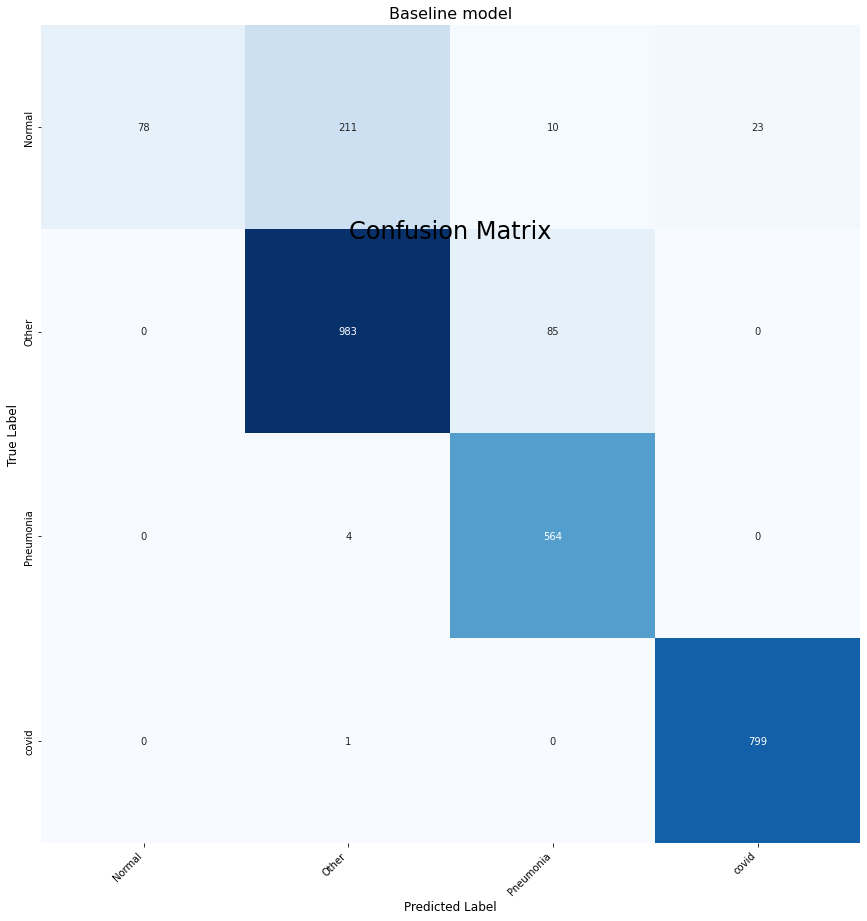

In [ ]:
#Visualizing the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

true_classes = test_generator.classes

class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(trueClass, predictedClass, class_names, ax1, title="Baseline model")    

fig.suptitle("Confusion Matrix", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

#### Pre-trained model - Xception

In [ ]:
#getting the feature extractor part of the model

pretrained= tf.keras.applications.Xception(include_top=False,
                   input_shape=(197,198, 3), weights='imagenet')

#Freezing all of its layers as we wish to retain it's parameters

pretrained.trainable=False


83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
#Model's classifier part

inputs = tf.keras.Input(shape=(197,198,3))
x = pretrained(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

xcep = tf.keras.Model(inputs, outputs)

#Getting the model architecture
xcep.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 197, 198, 3)]     0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 512)               37749248  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 58,612,780
Trainable params: 37,751,300
Non-tra

In [ ]:
#Compiling the model with the appropriate parameters

xcep.compile(loss="categorical_crossentropy",optimizer = 'rmsprop', metrics=["accuracy"])

#We wish to track the validation loss and save the best model

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath="x.keras",
                                            save_best_only=True,
                                            monitor="val_loss")


In [ ]:
#Training the model, the class weight parameter has been set up to the computed weights 
xcep.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 7 , validation_data= val_generator,
             validation_steps = len(val_generator), callbacks = [callbacks], class_weight = class_weights)

Epoch 1/7
19/19 [==============================] - 1977s 104s/step - loss: 54.2009 - accuracy: 0.6875 - val_loss: 68.0049 - val_accuracy: 0.6065
Epoch 2/7
19/19 [==============================] - 97s 5s/step - loss: 8.3339 - accuracy: 0.8928 - val_loss: 94.6509 - val_accuracy: 0.6007
Epoch 3/7
19/19 [==============================] - 100s 5s/step - loss: 7.1167 - accuracy: 0.9199 - val_loss: 1.4170 - val_accuracy: 0.9564
Epoch 4/7
19/19 [==============================] - 101s 5s/step - loss: 13.8068 - accuracy: 0.8766 - val_loss: 1.0567 - val_accuracy: 0.9644
Epoch 5/7
19/19 [==============================] - 98s 5s/step - loss: 2.4924 - accuracy: 0.9639 - val_loss: 4.0448 - val_accuracy: 0.9665
Epoch 6/7
19/19 [==============================] - 97s 5s/step - loss: 14.6255 - accuracy: 0.8699 - val_loss: 2.8105 - val_accuracy: 0.9680
Epoch 7/7
19/19 [==============================] - 96s 5s/step - loss: 1.7355 - accuracy: 0.9691 - val_loss: 2.4782 - val_accuracy: 0.9658


In [ ]:
xcep.save("classification.hdf5")

In [ ]:
import numpy as np

#The model is now being used for making predictions on the test dataset
predict = xcep.predict_generator(
    test_generator, workers=0, verbose=0
)

#Getting class of the predictions made
predictedClass = np.argmax(predict, axis=1)

#True class of every image in test data
trueClass = test_generator.classes[test_generator.index_array]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

#Computing the performance metrics
print("Precision score is ", precision_score(trueClass, predictedClass, average = "weighted"))
print("Accuracy score is ", accuracy_score(trueClass, predictedClass))
print("Recall is ",recall_score(trueClass, predictedClass,average = "weighted"))
print("F1 score is ",f1_score(trueClass, predictedClass,average = "weighted"))

Precision score is  0.9714525967822378
Accuracy score is  0.9691805656272662
Recall is  0.9691805656272662
F1 score is  0.9686410545255468


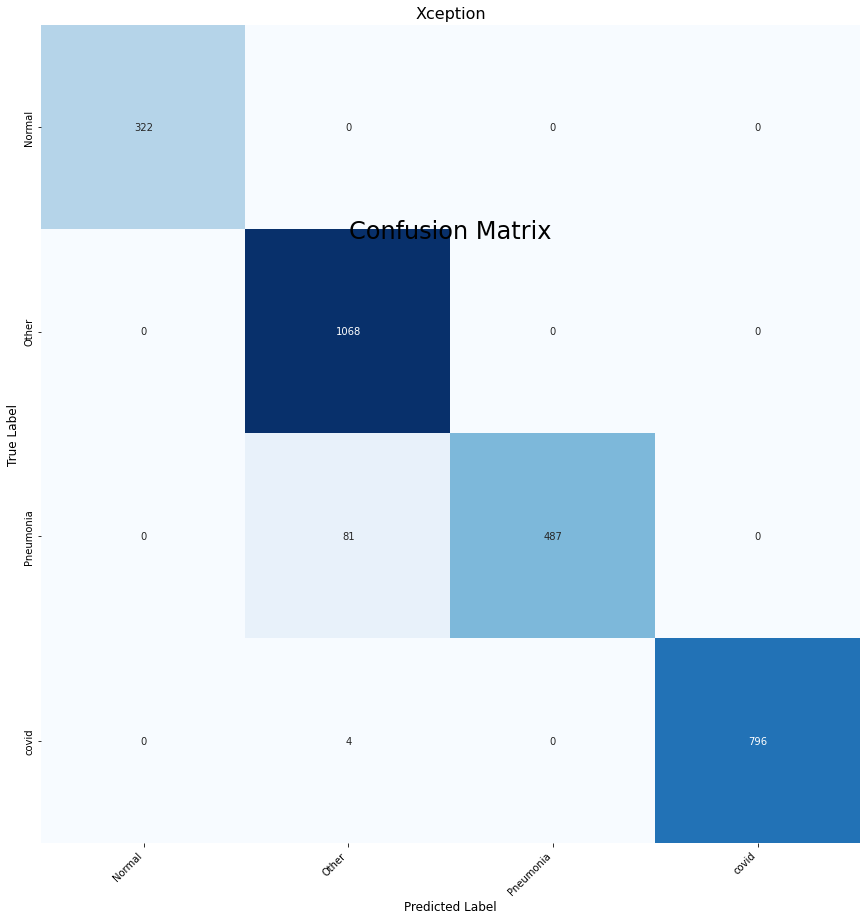

In [ ]:
#Visualizing the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

true_classes = test_generator.classes

class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(trueClass, predictedClass, class_names, ax1, title="Xception")    

fig.suptitle("Confusion Matrix", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
#Printing the classification report to get a picture of performance on all classes

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(classification_report(trueClass, predictedClass))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.93      1.00      0.96      1068
           2       1.00      0.86      0.92       568
           3       1.00      0.99      1.00       800

    accuracy                           0.97      2758
   macro avg       0.98      0.96      0.97      2758
weighted avg       0.97      0.97      0.97      2758

